
# Customer Churn Prediction — Clean Notebook

This notebook reorganizes your churn project into clear, runnable sections with human-friendly explanations.  
**Important:** The modeling **logic and parameters remain the same** so it will run end-to-end without code tracing.


## 1) Imports & Configuration

In [1]:
# All imports in one place (consolidated)

# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

# Modeling / pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve
)

np.set_printoptions(suppress=True)
pd.options.display.float_format = "{:,.2f}".format

print('Imports OK.')

Imports OK.


## 2) Load Data & Light Cleaning
Steps:
- Read the Excel file
- Normalize string columns (strip spaces)
- Safely coerce numerics
- Handle accidental missing values (consistent with your original logic)


In [2]:
# Path to Excel (keep your original path; change if needed)
DATA_PATH = r"C:\Users\HP\Documents\CalebOkoh_GrowthAnalyst_Assessment\synthetic_telco_churn.xlsx"

# 1) Load
df = pd.read_excel(DATA_PATH)

# 2) Trim spaces in strings
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# 3) Safely coerce numerics
num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 4) Fill any accidental NaNs (same fallback as before)
df["TotalCharges"] = df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"])
df = df.dropna(subset=["tenure", "MonthlyCharges", "TotalCharges", "Churn"])

print(df.dtypes.head())
display(df.head(3))

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST-00001,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),93.44,"2,056.28",Yes
1,CUST-00002,Female,0,No,Yes,51,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Electronic check,85.03,"4,344.27",Yes
2,CUST-00003,Male,1,No,No,9,Yes,No,Fiber optic,Yes,...,Yes,Yes,No,Yes,Month-to-month,No,Credit card (automatic),104.16,945.72,Yes


## 3) Feature Engineering
Business-meaningful features used in modeling. Logic preserved.


In [3]:
df_fe = df.copy()

# 1) Avg Monthly Spend (safe divide; fallback to MonthlyCharges if tenure==0)
df_fe['AvgMonthlySpend'] = np.where(
    df_fe['tenure'] > 0,
    df_fe['TotalCharges'] / df_fe['tenure'],
    df_fe['MonthlyCharges']
)

# 2) Number of selected services (count 'Yes' across service flags)
service_cols = [
    'PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'
]
df_fe['NumServices'] = df_fe[service_cols].apply(lambda s: (s == 'Yes').sum(), axis=1)

# 3) Internet_No_Services: has internet but none of the add-ons
addon_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
df_fe['Internet_No_Services'] = (
    (df_fe['InternetService'] != 'No') & df_fe[addon_cols].eq('No').all(axis=1)
).astype(int)

# 4) Tenure groups
def tenure_group(m):
    if m <= 12: return 'New'
    if m <= 24: return 'Medium'
    return 'Long'
df_fe['TenureGroup'] = df_fe['tenure'].apply(tenure_group)

# 5) ContractBinary: One/Two year -> 1, Month-to-month -> 0
df_fe['ContractBinary'] = df_fe['Contract'].isin(['One year','Two year']).astype(int)

# 6) Payment method group: Electronic check vs Others
df_fe['PayMethodGroup'] = np.where(df_fe['PaymentMethod'] == 'Electronic check', 'E-Check', 'Other')

# 7) Target flag
df_fe['ChurnFlag'] = (df_fe['Churn'] == 'Yes').astype(int)

display(df_fe[[
    'AvgMonthlySpend','NumServices','Internet_No_Services',
    'TenureGroup','ContractBinary','PayMethodGroup','Churn','ChurnFlag'
]].head())

,AvgMonthlySpend,NumServices,Internet_No_Services,TenureGroup,ContractBinary,PayMethodGroup,Churn,ChurnFlag
0,93.47,3,0,Medium,0,Other,Yes,1
1,85.18,3,0,Long,0,E-Check,Yes,1
2,105.08,5,0,New,0,Other,Yes,1
3,72.08,3,0,Long,0,Other,Yes,1
4,76.76,5,0,Long,1,Other,Yes,1


## 4) Quick EDA (Sanity Checks)

Class balance (%):
Churn
No    55.50
Yes   44.50
Name: proportion, dtype: float64

Numeric means by churn:


,tenure,MonthlyCharges,TotalCharges,AvgMonthlySpend,NumServices
Churn,,,,,
No,36.61,77.93,"2,851.44",77.92,3.27
Yes,35.71,78.29,"2,806.10",78.29,3.22


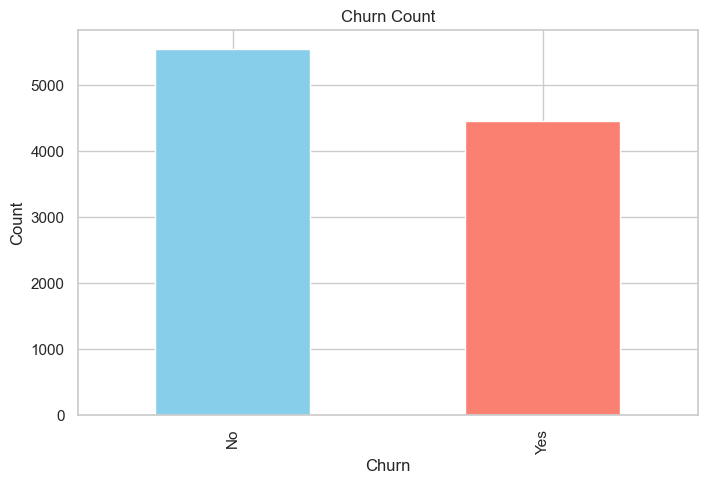

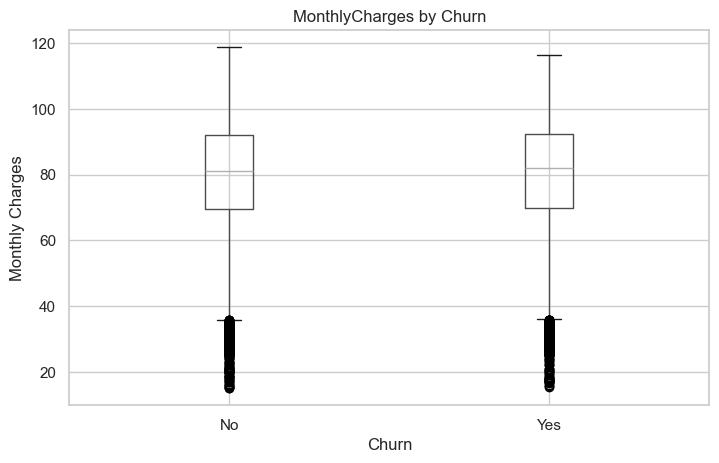

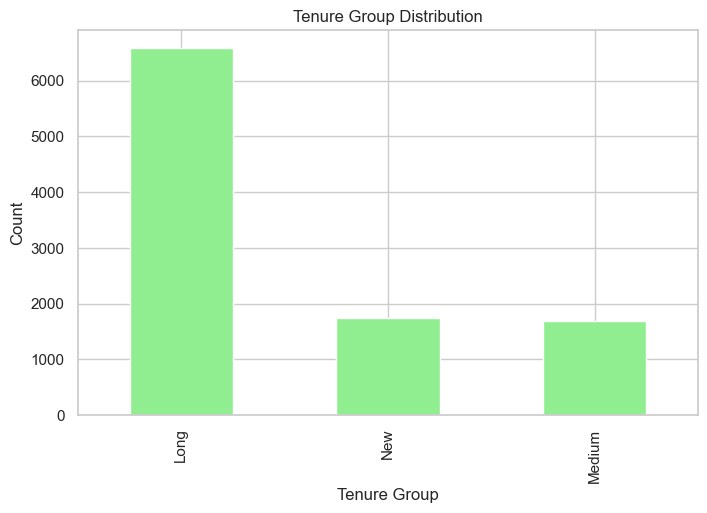

In [4]:
# Class balance
print('Class balance (%):')
print((df_fe['Churn'].value_counts(normalize=True) * 100).round(1))

# Numeric summaries
print('\nNumeric means by churn:')
display(
    df_fe.groupby('Churn')[['tenure','MonthlyCharges','TotalCharges','AvgMonthlySpend','NumServices']]
         .mean().round(2)
)

# Charts
df_fe['Churn'].value_counts().plot(kind='bar', title='Churn Count', color=['skyblue','salmon'])
plt.xlabel('Churn'); plt.ylabel('Count'); plt.show()

df_fe.boxplot(column='MonthlyCharges', by='Churn')
plt.title('MonthlyCharges by Churn'); plt.suptitle(''); plt.ylabel('Monthly Charges'); plt.show()

df_fe['TenureGroup'].value_counts().plot(kind='bar', title='Tenure Group Distribution', color='lightgreen')
plt.xlabel('Tenure Group'); plt.ylabel('Count'); plt.show()

## 5) Train/Test Split & Preprocessing
- Categorical & numeric column lists  
- Stratified split  
- ColumnTransformer: One-Hot for categoricals, StandardScaler for numerics  


In [5]:
# Feature lists (unchanged logic)
cat_cols = [
    'gender','Partner','Dependents','PhoneService','MultipleLines',
    'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
    'PayMethodGroup','TenureGroup'
]
num_cols = [
    'tenure','MonthlyCharges','TotalCharges','AvgMonthlySpend',
    'NumServices','Internet_No_Services','ContractBinary','SeniorCitizen'
]

X = df_fe[cat_cols + num_cols]
y = df_fe['ChurnFlag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

print('Split OK. Preprocess pipeline ready.')

Split OK. Preprocess pipeline ready.


## 6) Model Training — Random Forest
- Pipeline = preprocessing + classifier  
- Class weight balanced to account for ~55/45 split  


In [6]:
rf_pipeline = Pipeline(steps=[
    ('prep', preprocess),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_pipeline.fit(X_train, y_train)
print('Random Forest trained.')

Random Forest trained.


## 7) Baseline Metrics (Threshold = 0.50)

In [7]:
rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]
rf_pred  = (rf_proba >= 0.50).astype(int)

acc = accuracy_score(y_test, rf_pred)
prc = precision_score(y_test, rf_pred)
rcl = recall_score(y_test, rf_pred)
f1  = f1_score(y_test, rf_pred)
auc = roc_auc_score(y_test, rf_proba)

print(f'Accuracy : {acc:.3f}')
print(f'Precision: {prc:.3f}')
print(f'Recall   : {rcl:.3f}')
print(f'F1-score : {f1:.3f}')
print(f'ROC-AUC  : {auc:.3f}\n')
print('Confusion matrix:\n', confusion_matrix(y_test, rf_pred))
print('\nClassification report:\n', classification_report(y_test, rf_pred, digits=3))

Accuracy : 0.597
Precision: 0.554
Recall   : 0.479
F1-score : 0.514
ROC-AUC  : 0.620

Confusion matrix:
 [[767 343]
 [464 426]]

Classification report:
               precision    recall  f1-score   support

           0      0.623     0.691     0.655      1110
           1      0.554     0.479     0.514       890

    accuracy                          0.597      2000
   macro avg      0.589     0.585     0.584      2000
weighted avg      0.592     0.597     0.592      2000



## 8) Threshold Tuning — Target Higher Recall
For retention use-cases, it's often better to **catch more churners** (higher recall).  
This cell finds a threshold that achieves Recall ≥ 0.80.


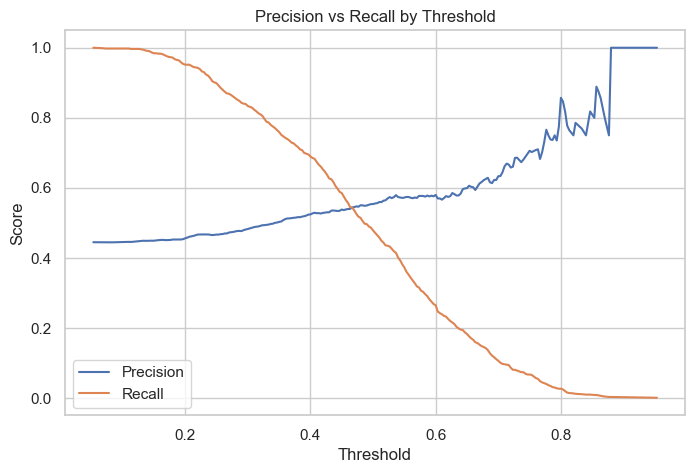

Chosen threshold for Recall >= 0.8: 0.323

Tuned Threshold Metrics:
Precision: 0.493
Recall   : 0.806
F1-score : 0.612
Confusion matrix:
 [[374 736]
 [173 717]]


In [8]:
prec, rec, thr = precision_recall_curve(y_test, rf_proba)

plt.figure(figsize=(8,5))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Score')
plt.title('Precision vs Recall by Threshold')
plt.legend(); plt.show()

target_recall = 0.80
idx = np.where(rec[:-1] >= target_recall)[0]
chosen_thr = thr[idx[-1]] if len(idx) else 0.50
print(f'Chosen threshold for Recall >= {target_recall}: {chosen_thr:.3f}')

rf_pred_tuned = (rf_proba >= chosen_thr).astype(int)
print('\nTuned Threshold Metrics:')
print('Precision:', precision_score(y_test, rf_pred_tuned).round(3))
print('Recall   :', recall_score(y_test, rf_pred_tuned).round(3))
print('F1-score :', f1_score(y_test, rf_pred_tuned).round(3))
print('Confusion matrix:\n', confusion_matrix(y_test, rf_pred_tuned))

## 9) Feature Importance — What Drives Churn?

Top 20 features:


,feature,importance
37,TotalCharges,0.12
36,MonthlyCharges,0.12
38,AvgMonthlySpend,0.12
35,tenure,0.10
39,NumServices,0.04
41,ContractBinary,0.03
25,Contract_Month-to-month,0.02
42,SeniorCitizen,0.02
2,Partner_No,0.02
28,PaperlessBilling_No,0.02


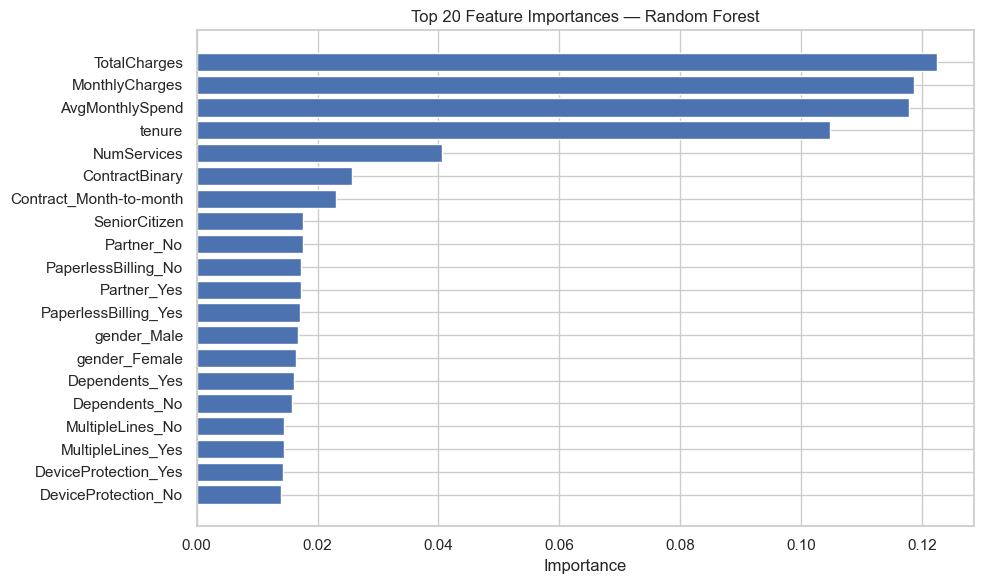

In [9]:
cat_encoder = rf_pipeline.named_steps['prep'].named_transformers_['cat']
cat_names = cat_encoder.get_feature_names_out(cat_cols)
feat_names = np.concatenate([cat_names, np.array(num_cols)])

importances = rf_pipeline.named_steps['rf'].feature_importances_
feat_imp = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)

print('Top 20 features:')
display(feat_imp.head(20))

plt.figure(figsize=(10,6))
plt.barh(feat_imp.head(20)['feature'], feat_imp.head(20)['importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances — Random Forest')
plt.xlabel('Importance'); plt.tight_layout(); plt.show()

## 10) Export Customer-Level Churn Scores
Exports probabilities for all customers and a Yes/No flag using the tuned threshold.


In [10]:
df_export = df_fe.copy()

# Probabilities on FULL dataset (X from Cell 5)
X_full = df_fe[cat_cols + num_cols]
proba_full = rf_pipeline.predict_proba(X_full)[:, 1]
df_export['Churn_Probability'] = proba_full

# Use tuned threshold from Cell 8
THRESHOLD = float(chosen_thr)
df_export['Predicted_Churn'] = np.where(df_export['Churn_Probability'] >= THRESHOLD, 'Yes', 'No')

# Minimal export columns
export_df = df_export[['customerID', 'Churn_Probability', 'Predicted_Churn']]
export_df.to_excel('churn_predictions.xlsx', index=False)
print('Exported: churn_predictions.xlsx')

Exported: churn_predictions.xlsx
